In [37]:
import os
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from utils import datasets
from utils import utils
import warnings

# 完全禁用警告
warnings.filterwarnings("ignore")

In [38]:
# from utils import Config,Logs,BestSelector


config=utils.Config(
    dataset_sep=[
        1,0,0          
        ],
    resize_size=128,
    batch_size=16,
    lr=0.001,
    epochs=30,
    hidden_size=256,
    optim="Adam",
    momentum=0.9,
    weight_decay=1e-4,
    seed=42,
    mean= [0.50638 ,0.49962538 ,0.45205265],
    std=[0.23568255 ,0.24141274 ,0.25167742],
    source_dir=r"data\lfw",
    data_path=r"data\lfw_split",
    classes=["Apple","Carambola","Pear","Plum","Tomatoes"],
    datasize=1000,
    device="cuda" if torch.cuda.is_available() else "cpu"
)

# classes

print(config)
# print(torch.cuda.is_available())

dataset_sep : [1, 0, 0] 
resize_size : 128 
batch_size : 32 
lr : 0.001 
epochs : 30 
hidden_size : 256 
optim : Adam 
momentum : 0.9 
weight_decay : 0.0001 
seed : 42 
mean : [0.50638, 0.49962538, 0.45205265] 
std : [0.23568255, 0.24141274, 0.25167742] 
source_dir : data\lfw 
data_path : data\lfw_split 
classes : ['Apple', 'Carambola', 'Pear', 'Plum', 'Tomatoes'] 
datasize : 1000 
device : cuda 


In [39]:
#设置随机数种子
torch.manual_seed(config.seed)

In [40]:
if False:
    datasets.split_data(
    data_path=config.source_dir,
    tartget_dir=config.data_path,
    dataset_sep=config.dataset_sep,
    datasize=config.datasize,
)

In [41]:
classes=os.listdir(config.source_dir)[:config.datasize]
config.update(classes=classes)
config

dataset_sep : [1, 0, 0] 
resize_size : 128 
batch_size : 32 
lr : 0.001 
epochs : 30 
hidden_size : 256 
optim : Adam 
momentum : 0.9 
weight_decay : 0.0001 
seed : 42 
mean : [0.50638, 0.49962538, 0.45205265] 
std : [0.23568255, 0.24141274, 0.25167742] 
source_dir : data\lfw 
data_path : data\lfw_split 
classes : ['Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abbas_Kiarostami', 'Abba_Eban', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_al-Attiyah', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullatif_Sener', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adelina_Avila', 'Adel_Al-Jubeir', 'Adis

In [42]:
def get_data_path(typ,path=config.data_path):
    return os.path.join(path,typ)
crop_rate=2000
train_dataset=datasets.CustomImageDataset(
    get_data_path('train'),
    classes=config.classes,
    transform=datasets.get_transform(
        resize_size=config.resize_size,
        mean=config.mean,std=config.std
        )
)
val_dataset=datasets.CustomImageDataset(
    get_data_path("train"),
    classes=config.classes,
    transform=datasets.get_transform(
        "train",
        config.resize_size,
        mean=config.mean,
        std=config.std
        )
)

print(f"train_datsets :{len(train_dataset)}\nval_datasets : {len(val_dataset)}")
train_loader=DataLoader(train_dataset,batch_size=config.batch_size,shuffle=True,drop_last=True)
val_loader=DataLoader(val_dataset,batch_size=config.batch_size,shuffle=False)
print(f"dataloader加载完毕,{len(train_loader)}")


train_datsets :2100
val_datasets : 2100
dataloader加载完毕,65


In [43]:
from utils import net
def get_pretrained(hidden_size=config.hidden_size,config=config):
    # model=net.BinaryClassificationMobileNetV3Large(out_size=len(config.classes))
    model=net.CustomEfficientNet_b1(len(config.classes),hidden_size=hidden_size)
    # model=net.CustomResNet(len(config.classes),hidden_size=hidden_size)
    # model=net.CustomEfficientNet_b1(len(config.classes),hidden_size=512)
    return model.to(config.device)
    # return model



In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import average_precision_score
def weighted_average_metrics(acc, ap, precision , recall, loss, weights=[30, 1.2, 1,1, 1.05]):
    loss=1-loss
    weighted_acc = acc * weights[0]
    weighted_ap = ap * weights[1]
    weighted_precision=precision*weights[2]
    weighted_recall = recall * weights[3]
    weighted_loss = loss * weights[4]

    weighted_average = (weighted_acc + weighted_ap + weighted_precision + weighted_recall + weighted_loss) / sum(weights)

    return weighted_average


In [45]:
#查看数据加载情况
for inputs, labels in train_loader:
    print(inputs.dtype)
    inputs=inputs.to(config.device)
    labels=labels.to(config.device)
    
    print(labels.reshape(-1,1).squeeze().shape)
    break

torch.float32
torch.Size([32])


In [46]:
# 定义训练
import numpy as np
from tqdm import tqdm

def float_equal(a, b, epsilon=1e-4):
    return abs(a - b) < epsilon

# 使用示例

def train_model(model, criterion, optimizer, train_loader, val_loader,bestMod,train_logs, num_epochs=config.epochs):
    train_loss_lst=[]
    val_acc_lst=[]
    precision_lst=[] 
    recall_lst=[]
    f1_lst=[]
    ap_lst=[]
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs=inputs.to(config.device)
            labels=labels.to(config.device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 打印每个epoch的训练损失
        epoch_loss=running_loss / len(train_loader)

        # 在验证集上评估模型
        model.eval()
        correct = 0
        total = 0
        true_labels = []
        predicted_labels = []
        predicted_scores = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs=inputs.to(config.device)
                labels=labels.to(config.device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                true_labels.extend(labels.cpu().numpy())
                predicted_labels.extend(predicted.cpu().numpy())
                predicted_scores.extend(outputs[:, 1].cpu().numpy())
        
        # 验证准确率
        
        accuracy = accuracy_score(true_labels, predicted_labels)
        precision = precision_score(true_labels, predicted_labels,average="macro")
        recall = recall_score(true_labels, predicted_labels,average="macro")
        f1 = f1_score(true_labels, predicted_labels,average="macro")
        ap = average_precision_score(np.array(true_labels).reshape(-1, 1), np.array(predicted_scores).reshape(-1, 1))

        train_loss_lst.append(epoch_loss)
        val_acc_lst.append(accuracy)
        precision_lst.append(precision)
        recall_lst.append(recall)
        f1_lst.append(f1)
        ap_lst.append(ap)
        zh=weighted_average_metrics(
            acc=accuracy, recall=recall, ap=ap,loss=loss, precision=precision
        )
        try:
            mod_zh=weighted_average_metrics(
                acc=bestMod.acc,
                ap=bestMod.ap,
                loss=bestMod.loss,
                recall=bestMod.recall,
                precision=precision
            )
        except:
            mod_zh=0
        if zh >= mod_zh:
            if float_equal(zh,mod_zh):
                if epoch_loss<bestMod.loss:
                    bestMod.update(
                        acc=accuracy,
                        model=model,
                        loss=epoch_loss,
                        precision=precision,
                        recall=recall,
                        ap=ap,
                        # f1=f1,
                        epoch=epoch,
                    )
            else:
                bestMod.update(
                        acc=accuracy,
                        model=model,
                        loss=epoch_loss,
                        # f1=f1,
                        precision=precision,
                        recall=recall,
                        epoch=epoch,
                        ap=ap
                    )
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)},  Val Accuracy: {accuracy}, AP:{ap} ,Precision:{precision}, Recall:{recall}')
        print(f"当前最好的模型： {str(bestMod)}")
    train_logs.update(
        train_loss_lst=train_loss_lst,
        val_acc_lst=val_acc_lst,
        precision_lst=precision_lst,
        recall_lst=recall_lst,
        f1_lst=f1_lst,
        ap_lst=ap_lst,
    )
    return bestMod,train_logs




In [47]:
config.update(
        epochs=20
    )
print(config)

dataset_sep : [1, 0, 0] 
resize_size : 128 
batch_size : 32 
lr : 0.001 
epochs : 20 
hidden_size : 256 
optim : Adam 
momentum : 0.9 
weight_decay : 0.0001 
seed : 42 
mean : [0.50638, 0.49962538, 0.45205265] 
std : [0.23568255, 0.24141274, 0.25167742] 
source_dir : data\lfw 
data_path : data\lfw_split 
classes : ['Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abbas_Kiarostami', 'Abba_Eban', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_al-Attiyah', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullatif_Sener', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adelina_Avila', 'Adel_Al-Jubeir', 'Adis

In [48]:
bestMod=utils.BestSelector(acc=0)
train_logs=utils.Logs()


resnet_model=get_pretrained()
# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
if config.optim == "Adam":
    optimizer = optim.Adam(resnet_model.parameters(), lr=config.lr)
else:
    optimizer = optim.SGD(resnet_model.parameters(), lr=config.lr, momentum=0.9, weight_decay=1e-4)
    
bestMod,train_logs=train_model(
            resnet_model, 
            criterion,
            optimizer, 
            train_loader,
            val_loader,
            bestMod=bestMod,
            train_logs=train_logs,
            num_epochs=config.epochs
        )

  0%|          | 0/20 [00:02<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 22.00 MiB (GPU 0; 6.00 GiB total capacity; 5.06 GiB already allocated; 0 bytes free; 5.33 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
print(f"{config.epochs} epoch中 最好的模型")
print(bestMod)

40 epoch中 最好的模型
acc : 1.0 ,loss : 0.06075358022935688 ,precision : 1.0 ,recall : 1.0 ,epoch : 18 ,ap : 0.00980392156862745 


In [ ]:
saveDir=r'save_weights'
utils.saveProcess(
    saveDir=os.path.join(saveDir,f'{bestMod.model.__class__.__name__}-acc={round(bestMod.acc,5)}-loss={round(bestMod.loss,6)}-max_epochs={config.epochs}-1100'),
    bestMod=bestMod,
    train_log=train_logs,
    config=config
)

save_weights\CustomEfficientNet_b1-acc=1.0-loss=0.060754-max_epochs=40-1100


In [ ]:
from tqdm import tqdm
def test(model,split=False,testdata_path=r'test_dir'):
    model.to(config.device)
    test_dataset=datasets.CustomImageDataset(testdata_path)
    transform=datasets.get_transform("val")

    # test_loader=DataLoader(test_dataset,batch_size=4)
    total,correct=0,0
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        predicted_scores=[]
        labels=[]
        for img,label in tqdm(test_dataset):
            if split :
                imgs=imgs[0]
            else:
                imgs=[imgs[1]]
            pred=0
        # if True:
            for inputs in imgs:
                inputs=inputs.to(config.device)
                

                outputs = model(inputs)
                print(outputs)
                _, predicted = torch.max(outputs.data, 1)
                pre=predicted.item()
                predicted_scores.extend(outputs[:, 1].cpu().numpy())
                labels.extend([label])
                if pre==1:
                    pred=1
                    break
            if label==pred:
                correct+=1
            total += 1

    print(f"测试集准确率:{correct/total}")
    return labels,predicted_scores

In [ ]:
def get_ROCandAUC(labels,preds_prob):
    fpr, tpr, thresholds = roc_curve([labels], [preds_prob])
    auc_score =  roc_auc_score([labels], [preds_prob])
    return fpr,tpr,auc_score


In [ ]:
import numpy as np
def softmax(x):
    exp_x = np.exp(x - np.max(x))  # 减去最大值，防止数值溢出
    return exp_x / exp_x.sum()

In [ ]:
import torch
from utils import test,utils
import os
dir=r"model_dir"
config=utils.Config(os.path.join(dir,'config.json'))
model=utils.BestSelector(os.path.join(dir,'metrics.json'))

labels,predicted_scores=test.test(
                            config,
                            model.model,
                            testdata_path=r"test_data_path"
)



ImportError: cannot import name 'test' from 'utils' (d:\Desktop\深度学习\11.大三下课设\人脸识别\utils\__init__.py)

In [ ]:
import json


fpr,tpr,auc_score=test.get_ROCandAUC(
    labels,
    predicted_scores
)
res={
    "fpr":fpr.tolist(),
    "tpr":tpr.tolist(),
    "auc_score":auc_score
}
json.dump(res,open("roc.json",mode='w'))


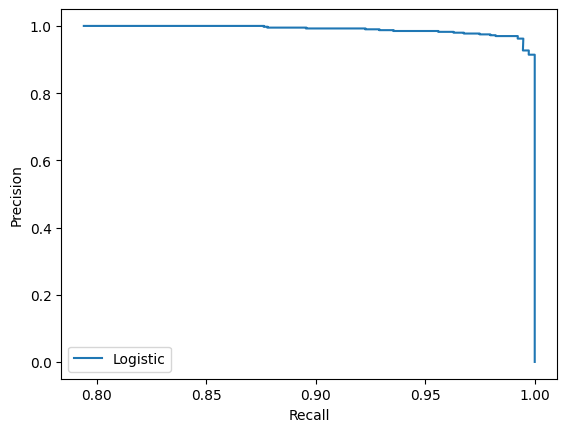

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, threshold = precision_recall_curve(
    labels,
    predicted_scores, 
    pos_label=1
    )
res={
    "precision":precision.tolist(),
    "recall":recall.tolist()
}
json.dump(res,open("pr.json",mode='w'))
fig = plt.figure()
plt.plot(precision, recall, label='Logistic')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

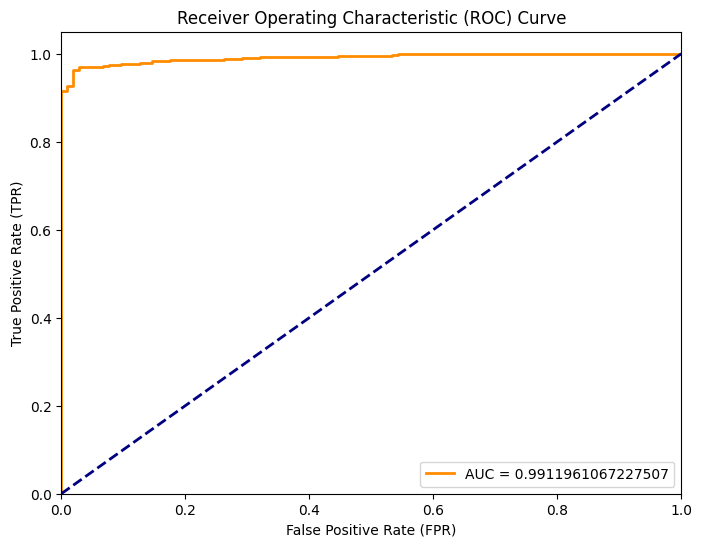

In [ ]:
# fpr,tpr,auc_score=get_ROCandAUC(labels,predicted_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
import json


fpr,tpr,auc_score=test.get_ROCandAUC(
    labels,
    predicted_scores
    )
# fpt_train,tpr_train,auc_train=train_logs.
res={
    "fpr":fpr.tolist(),
    "tpr":tpr.tolist(),
    "auc_score":auc_score
}
# json.dump(res,open("roc.json",mode='w'))